# Computing Expressibility

In this notebook, we give an example of how to compute expressibility of a quanvolutional model.

In [48]:
import constants


from scipy.stats import entropy


from quanvs.quanv_util import default_encoding_config


from quanvs.quanv_util import default_encoding_config
from quanvs.Quanvolutional_Layer import QuanvolutionalLayer

import torch.nn.functional as F

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.expressibility import compute_avg_fidelity

In [49]:
def haar_fidelity_cdf(f, Nq):
    """
    Compute Haar fidelity cumulative density function given a fidelity value
    and the size of the quantum system (#qubits).
    """
    Nh = Nq ** 2
    return 1 - (1 - f) ** (Nh - 1)

In [50]:
n_qubits = 4
bins = 50
kernel_size = 2

n_patches = 2**8 
average_over = 10 

L_min = 2
L_max = 30

step = 1

encoding = constants.CircuitEncoding.INTEGRATED
encoding_config = default_encoding_config(encoding)
encoding_config["n_qubits"] = n_qubits


In [51]:
results_RndMul = []

encoding_config["activation"] = constants.QuanvActivation.FULL.value #rand lin
for L in tqdm(range(L_min, L_max+1, step)):

    for _ in range(average_over): 
        encoding_config["L"] = L
        layer_integrated = QuanvolutionalLayer(1, 1, kernel_size, stride=1, padding=1, quantization=None, encoding_approach=encoding, encoding_config=encoding_config, verbose=False)
        circuit = layer_integrated.circuits[0]

        fidelities = compute_avg_fidelity(n_qubits, circuit, n_patches, n_params=kernel_size**2)


        bin_edges = np.linspace(0, 1, bins+1)
        hist, _ = np.histogram(fidelities, bins=bin_edges)

        hist = hist / np.sum(hist)
        Nh = len(hist)
        haar_cfd = np.zeros(Nh)
        for i in range(Nh):
            haar_cfd[i] = (haar_fidelity_cdf(bin_edges[i + 1], n_qubits) -
                        haar_fidelity_cdf(bin_edges[i], n_qubits))

        haar_cfd += 10**-16

        kl_div = entropy(hist, haar_cfd)
        #print(kl_div)

        #pqc_result = pqc_integral(4, circuit, 2**10, n_params=kernel_size**2) #2**10 = 1024
        

        # Append result to the list
        results_RndMul.append([L, kl_div])

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [06:55<00:00, 14.34s/it]


In [52]:
results_RndLin = []

encoding_config["activation"] = constants.QuanvActivation.RANDOM.value #rand lin
for L in tqdm(range(L_min, L_max+1, step)):

    for _ in range(average_over): 
        encoding_config["L"] = L
        layer_integrated = QuanvolutionalLayer(1, 1, kernel_size, stride=1, padding=1, quantization=None, encoding_approach=encoding, encoding_config=encoding_config, verbose=False)
        circuit = layer_integrated.circuits[0]

        fidelities = compute_avg_fidelity(n_qubits, circuit, n_patches, n_params=kernel_size**2)


        bin_edges = np.linspace(0, 1, bins+1)
        hist, _ = np.histogram(fidelities, bins=bin_edges)

        hist = hist / np.sum(hist)
        Nh = len(hist)
        haar_cfd = np.zeros(Nh)
        for i in range(Nh):
            haar_cfd[i] = (haar_fidelity_cdf(bin_edges[i + 1], n_qubits) -
                        haar_fidelity_cdf(bin_edges[i], n_qubits))

        haar_cfd += 10**-16

        kl_div = entropy(hist, haar_cfd)
        #print(kl_div)

        #pqc_result = pqc_integral(4, circuit, 2**10, n_params=kernel_size**2) #2**10 = 1024
        

        # Append result to the list
        results_RndLin.append([L, kl_div])

100%|██████████| 29/29 [07:04<00:00, 14.63s/it]


In [53]:
results_Simple = []

encoding_config["activation"] = constants.QuanvActivation.FIXED.value #rand lin
for L in tqdm(range(L_min, L_max+1, step)):

    for _ in range(average_over): 
        encoding_config["L"] = L
        layer_integrated = QuanvolutionalLayer(1, 1, kernel_size, stride=1, padding=1, quantization=None, encoding_approach=encoding, encoding_config=encoding_config, verbose=False)
        circuit = layer_integrated.circuits[0]

        fidelities = compute_avg_fidelity(n_qubits, circuit, n_patches, n_params=kernel_size**2)


        bin_edges = np.linspace(0, 1, bins+1)
        hist, _ = np.histogram(fidelities, bins=bin_edges)

        hist = hist / np.sum(hist)
        Nh = len(hist)
        haar_cfd = np.zeros(Nh)
        for i in range(Nh):
            haar_cfd[i] = (haar_fidelity_cdf(bin_edges[i + 1], n_qubits) -
                        haar_fidelity_cdf(bin_edges[i], n_qubits))

        haar_cfd += 10**-16

        kl_div = entropy(hist, haar_cfd)
        #print(kl_div)

        #pqc_result = pqc_integral(4, circuit, 2**10, n_params=kernel_size**2) #2**10 = 1024
        

        # Append result to the list
        results_Simple.append([L, kl_div])

100%|██████████| 29/29 [06:53<00:00, 14.27s/it]


In [54]:
df_Simple = pd.DataFrame(results_Simple, columns=["L", "norm_diff"])
df_RndMul = pd.DataFrame(results_RndMul, columns=["L", "norm_diff"])
df_RndLin = pd.DataFrame(results_RndLin, columns=["L", "norm_diff"])


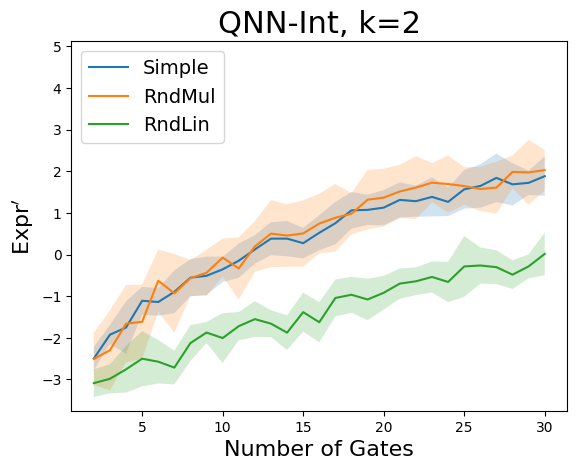

In [55]:
from scipy.ndimage import gaussian_filter1d

IS_LaTeX_INSTALLED = False # Set to True if LaTeX is installed on your system

plt.rcParams['text.usetex'] = IS_LaTeX_INSTALLED

fig, ax = plt.subplots()
for df in [df_Simple, df_RndMul, df_RndLin]:

    df['norm_diff_prime'] = -np.log(df['norm_diff'])
    df_filtered = df[(df["L"] >= L_min) & (df["L"] <= L_max)]
    df_grouped = df_filtered.groupby("L").agg(['mean', 'std']).reset_index()
    L_values = df_grouped[('L', '')].values
    mean_values = gaussian_filter1d(df_grouped[('norm_diff_prime', 'mean')].values, sigma=0.3)
    std_values = gaussian_filter1d(df_grouped[('norm_diff_prime', 'std')].values, sigma=0.3)
    mean_minus_std = mean_values - std_values
    mean_plus_std = mean_values + std_values

    if IS_LaTeX_INSTALLED:
        if df is df_Simple:
            legend_names = r"\textsc{Simple}"
        elif df is df_RndMul:
            legend_names = r"\textsc{RndMul}"
        elif df is df_RndLin:
            legend_names = r"\textsc{RndLin}"
    else:
        if df is df_Simple:
            legend_names = "Simple"
        elif df is df_RndMul:
            legend_names = "RndMul"
        elif df is df_RndLin:
            legend_names = "RndLin"

    ax.plot(L_values, mean_values, label=legend_names)
    ax.fill_between(L_values, 
                    mean_minus_std, 
                    mean_plus_std, 
                    alpha=0.2)

if IS_LaTeX_INSTALLED:
    ax.set_title(r"\textsc{{QNN-Int}}, $k={}$".format(kernel_size), fontsize=22)
    ax.set_ylabel("Expr$'$", fontsize=16)
else:
    ax.set_title(r"QNN-Int, k={}".format(kernel_size), fontsize=22)
    ax.set_ylabel("Expr$'$", fontsize=16)
ax.set_xlabel("Number of Gates", fontsize=16)
ax.set_ylim(-3.75, 5.125)
ax.legend(fontsize=14)

plt.show()